In [1]:
# Import libararies
import nltk
#nltk.download('wordnet')
from nltk.corpus import wordnet
import re
import pandas as pd  # to read files
from nltk.corpus import stopwords
import numpy as np
import sklearn


import nltk

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score ,confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

In [2]:
news = pd.read_json('news.json', lines=True)
news['information'] = news[['headline', 'short_description']].apply(lambda x: ' '.join(x), axis=1)

In [3]:
# Dataset dimension(row, columns)
news.shape

(124989, 7)

In [4]:
# To display entire text
pd.set_option('display.max_colwidth', -1)

In [5]:
news.head(5)

,authors,category,date,headline,link,short_description,information
0,Melissa Jeltsen,CRIME,2018-05-26,"There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV",https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89,She left her husband. He killed their children. Just another day in America.,"There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV She left her husband. He killed their children. Just another day in America."
1,Andy McDonald,ENTERTAINMENT,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song,https://www.huffingtonpost.com/entry/will-smith-joins-diplo-and-nicky-jam-for-the-official-2018-world-cup-song_us_5b09726fe4b0fdb2aa541201,Of course it has a song.,Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song Of course it has a song.
2,Ron Dicker,ENTERTAINMENT,2018-05-26,Hugh Grant Marries For The First Time At Age 57,https://www.huffingtonpost.com/entry/hugh-grant-marries_us_5b09212ce4b0568a880b9a8c,The actor and his longtime girlfriend Anna Eberstein tied the knot in a civil ceremony.,Hugh Grant Marries For The First Time At Age 57 The actor and his longtime girlfriend Anna Eberstein tied the knot in a civil ceremony.
3,Ron Dicker,ENTERTAINMENT,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork,https://www.huffingtonpost.com/entry/jim-carrey-adam-schiff-democrats_us_5b0950e8e4b0fdb2aa53e675,The actor gives Dems an ass-kicking for not fighting hard enough against Donald Trump.,Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork The actor gives Dems an ass-kicking for not fighting hard enough against Donald Trump.
4,Ron Dicker,ENTERTAINMENT,2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog,https://www.huffingtonpost.com/entry/julianna-margulies-trump-poop-bag_us_5b093ec2e4b0fdb2aa53df70,"The ""Dietland"" actress said using the bags is a ""really cathartic, therapeutic moment.""","Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog The ""Dietland"" actress said using the bags is a ""really cathartic, therapeutic moment."""


In [6]:
# Drop those rows which has authors and short_description column as empty.
news.drop(news[(news['authors'] == '') & (news['short_description'] == '' )].index, inplace=True)


# Some analysis on "category" of news

In [7]:
news.groupby(by='category').size()

category
ARTS              1490 
ARTS & CULTURE    1339 
BLACK VOICES      3714 
BUSINESS          4022 
COLLEGE           1094 
COMEDY            3951 
CRIME             2655 
EDUCATION         1004 
ENTERTAINMENT     13789
FIFTY             1288 
GOOD NEWS         1391 
GREEN             2427 
HEALTHY LIVING    6525 
IMPACT            2566 
LATINO VOICES     1121 
MEDIA             2723 
PARENTS           3906 
POLITICS          31869
QUEER VOICES      4831 
RELIGION          2263 
SCIENCE           1280 
SPORTS            4033 
STYLE             2158 
TASTE             2089 
TECH              1231 
THE WORLDPOST     3664 
TRAVEL            2138 
WEIRD NEWS        2603 
WOMEN             3383 
WORLD NEWS        2177 
WORLDPOST         1805 
dtype: int64

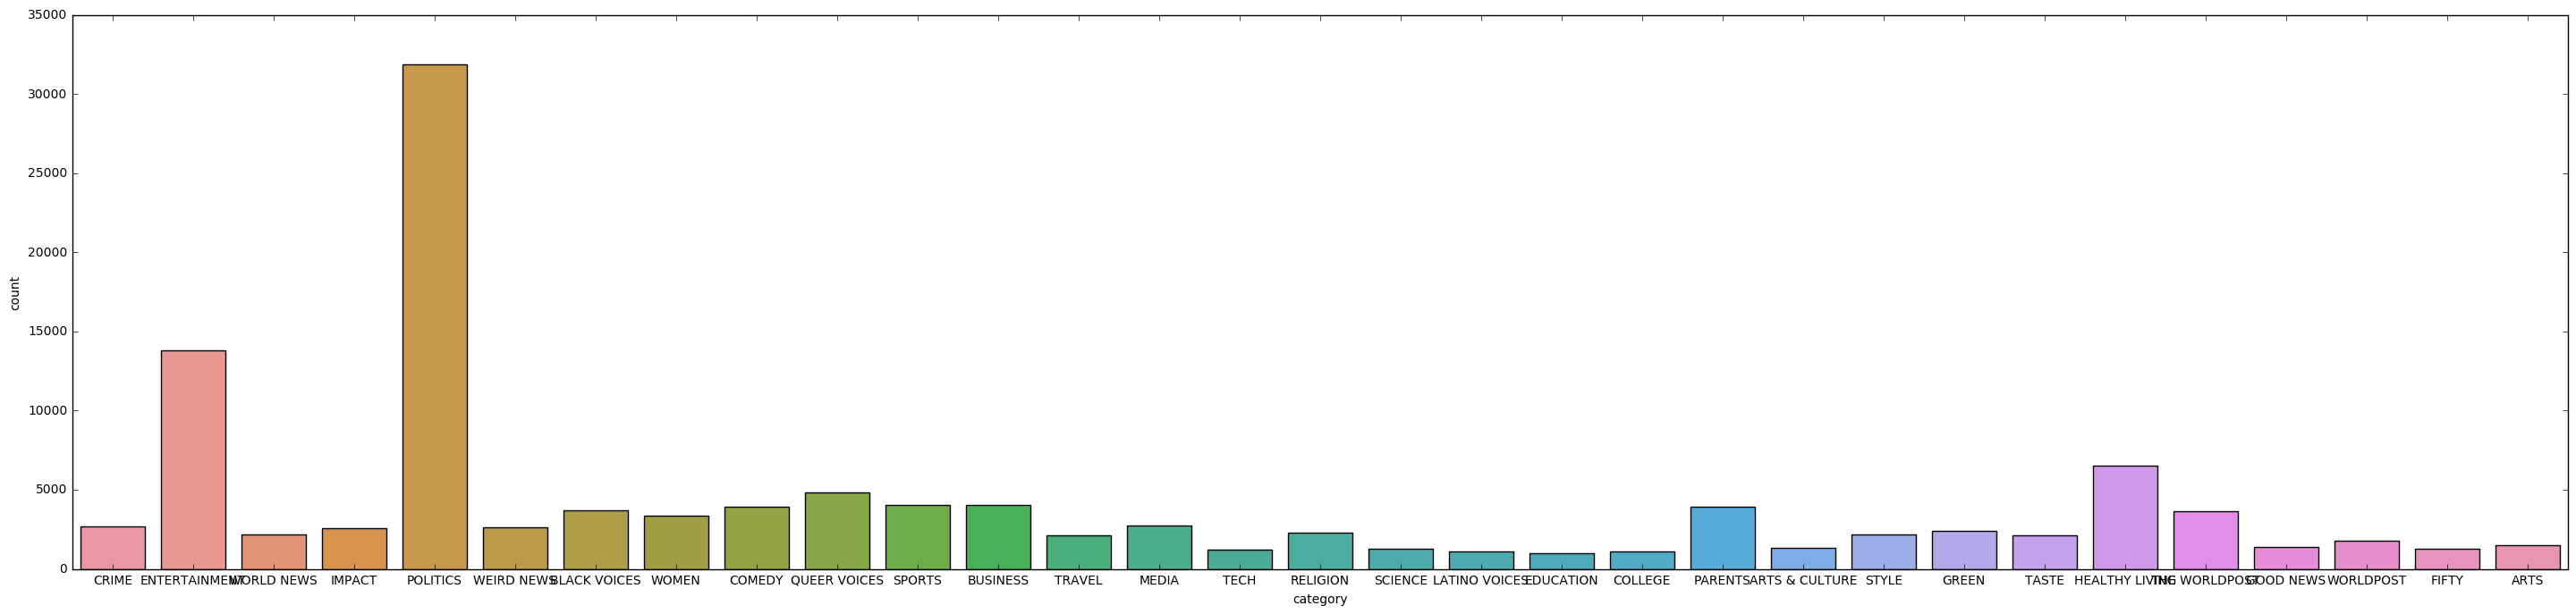

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(36,8))
sns.countplot(x = 'category', data = news)

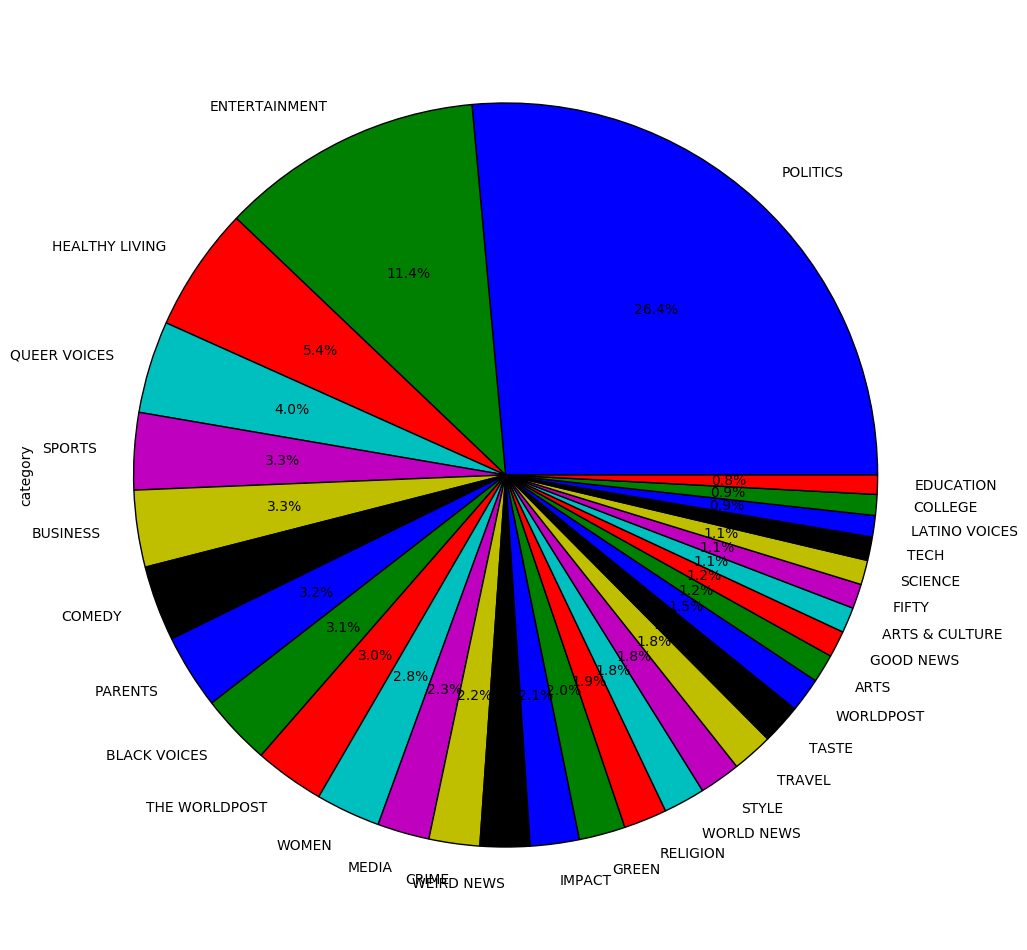

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
news['category'].value_counts().plot.pie( autopct = '%1.1f%%')

#### We can see that almost 38% of the news is of category POLITICS and ENTERTAINMENT. I think we shoud focus more on these 2 category for time being.

# Some analysis on author to see if "authors" has any relationship with category

In [10]:
#count the number of author in the dataset
#news.authors.value_counts()
total_authors = news.authors.nunique()
news_counts = news.shape[0]
print('Total Number of authors : ', total_authors)
print('avg articles written by per author: ' + str(news_counts//total_authors))
print('Total news counts : ' + str(news_counts))

Total Number of authors :  19250
avg articles written by per author: 6
Total news counts : 120529


In [11]:
authors_news_counts = news.authors.value_counts()
sum_contribution = 0
author_count = 0
for author_contribution in authors_news_counts:
    author_count += 1
    if author_contribution < 80:
        break
    sum_contribution += author_contribution
print('{} of news is contributed by {} authors i.e  {} % of news is contributed by {} % of authors'.
      format(sum_contribution, author_count, format((sum_contribution*100/news_counts), '.2f'), format((author_count*100/total_authors), '.2f')))

71711 of news is contributed by 194 authors i.e  59.50 % of news is contributed by 1.01 % of authors


#### We can observe that ~1% of authors are contributing to ~61% of the news. 

### If all authors are writing only of few categories of news then we can consider the author feature as well for modeling.

In [12]:
news.authors.value_counts()[0:12]

                     9691
Lee Moran            2423
Ron Dicker           1802
Ed Mazza             1320
Cole Delbyck         1140
Andy McDonald        1065
Julia Brucculieri    1059
Carly Ledbetter      1023
Curtis M. Wong       1005
Mary Papenfuss       974 
Bill Bradley         965 
Sam Levine           893 
Name: authors, dtype: int64

In [13]:
author_name = 'Lee Moran'
#author_name = 'Ed Mazza'
particular_author_news = news[news['authors'] == author_name]
df = particular_author_news.groupby(by='category')['information'].count()
df

category
ARTS & CULTURE    41 
BLACK VOICES      29 
BUSINESS          2  
COMEDY            779
CRIME             92 
EDUCATION         1  
ENTERTAINMENT     387
GOOD NEWS         74 
GREEN             2  
IMPACT            12 
LATINO VOICES     6  
MEDIA             46 
PARENTS           41 
POLITICS          263
QUEER VOICES      6  
RELIGION          7  
SCIENCE           46 
SPORTS            101
STYLE             3  
TASTE             12 
TECH              18 
THE WORLDPOST     25 
TRAVEL            4  
WEIRD NEWS        390
WOMEN             25 
WORLD NEWS        11 
Name: information, dtype: int64

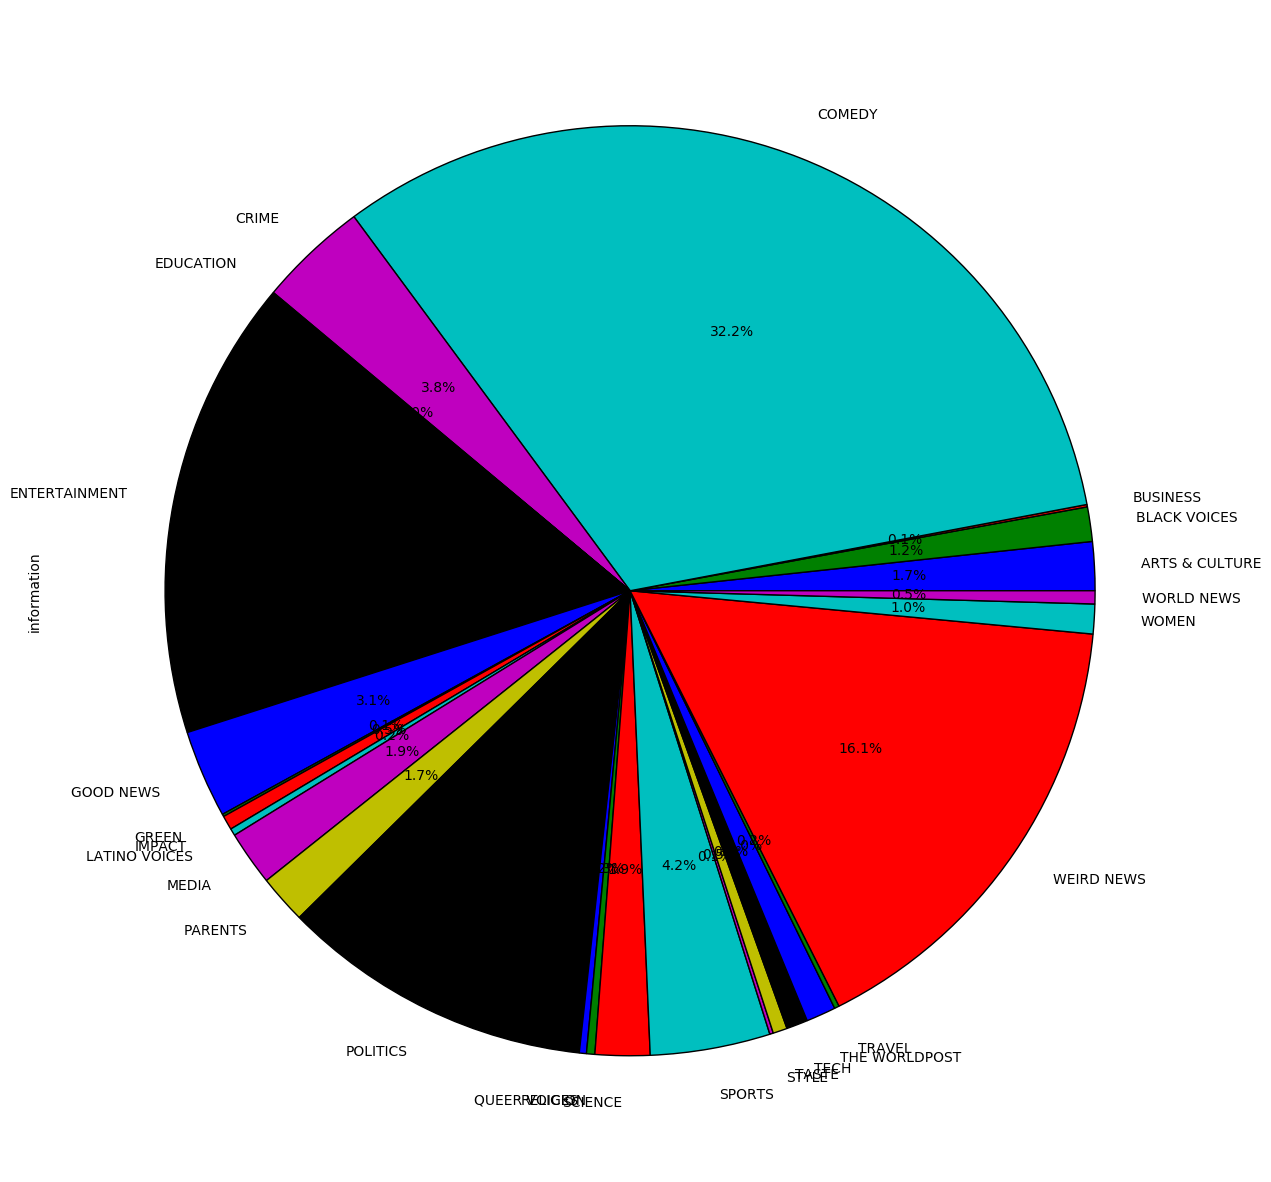

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))
df.plot.pie( autopct = '%1.1f%%')

In [15]:
from wordcloud import WordCloud
text = " ".join(news['category'])
wordcloud = WordCloud().generate(text)
plt.figure()
plt.subplots(figsize=(20,12))
wordcloud = WordCloud(
    background_color="white",
    max_words=len(text),
    max_font_size=40,
    relative_scaling=.5).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

ImportError: No module named 'wordcloud'

### We can observe that even though authors are  writing for almost all category but majority of their contribution

In [ ]:
# Split the data into train and test.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(news[['information', 'authors']], news['category'], test_size=0.33)

In [ ]:
# Convert pandas series into numpy array
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

#To append processed headlines
cleanHeadlines_train = [] 
cleanHeadlines_test = []

#Calculating the number of reviews
number_reviews_train = len(X_train) 
number_reviews_test = len(X_test) 

In [ ]:
nltk.download('wordnet')



In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

In [ ]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
lemmetizer = WordNetLemmatizer()
stemmer = PorterStemmer()
def get_words(headlines_list):
    headlines = headlines_list[0]   
    author_names = [x for x in headlines_list[1].lower().replace('and',',').replace(' ', '').split(',') if x != '']
    headlines_only_letters = re.sub('[^a-zA-Z]', ' ', headlines)
    words = nltk.word_tokenize(headlines_only_letters.lower())
    stops = set(stopwords.words('english'))
    meaningful_words = [lemmetizer.lemmatize(w) for w in words if w not in stops]
    return ' '.join(meaningful_words + author_names)

In [ ]:
 nltk.download('stopwords')
from nltk.corpus import stopwords

In [ ]:
for i in range(0,number_reviews_train):
    #Processing the data and getting words with no special characters, numbers or html tags
    
    cleanHeadline = get_words(X_train[i]) 
    cleanHeadlines_train.append( cleanHeadline )

In [ ]:
for i in range(0,number_reviews_test):
    #Processing the data and getting words with no special characters, numbers or html tags
    cleanHeadline = get_words(X_test[i])
    cleanHeadlines_test.append( cleanHeadline )
cleanHeadline

In [ ]:
vectorize = sklearn.feature_extraction.text.TfidfVectorizer(analyzer = "word", max_features=10000)
tfidwords_train = vectorize.fit_transform(cleanHeadlines_train)
X_train = tfidwords_train.toarray()
#tfidwords_train.toarray()
tfidwords_test = vectorize.transform(cleanHeadlines_test)
X_test = tfidwords_test.toarray()

In [ ]:
from sklearn.svm import LinearSVC

model = LinearSVC()
model.fit(X_train,Y_train)
Y_predict = model.predict(X_test)
accuracy = accuracy_score(Y_test,Y_predict)*100
print(format(accuracy, '.2f'))

In [ ]:
logistic_Regression = LogisticRegression()
#logistic_Regression.fit(np.transpose(np.matrix(X_train)), np.transpose(np.matrix(Y_train)))
logistic_Regression.fit(X_train,Y_train)
Y_predict = logistic_Regression.predict(X_test)
accuracy = accuracy_score(Y_test,Y_predict)*100
print(format(accuracy, '.2f'))

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='rbf',C=1,gamma=0.1)
model.fit(X_train, Y_train)
predict_rsvm = model.predict(X_test)
print('Predict accuracy is ',accuracy_score(predict_rsvm,Y_test))